In [38]:
from datetime import datetime
from alpha_realtime_stock import AlphaRealtimeStock
import time
import timeit
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout   ## importing layers of Neural network
from keras.callbacks import ModelCheckpoint     ## imporing modelcheck pointer
from keras.losses import MSE                  ## importing error function
from keras.optimizers import Adam              ## importing optimizer
from keras.activations import relu


def get_crumbs():
    """
    get crumb  from yahoo finance
    returns crumb
    """
    url = 'https://finance.yahoo.com/quote'
    header = {'Connection': 'keep-alive',
              'Expires': '-1',
              'Upgrade-Insecure-Requests': '1',
              'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) \
               AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36'
              }

    website = requests.get(url, headers=header)
    soup = BeautifulSoup(website.text, 'lxml')
    crumb = re.findall('"CrumbStore":{"crumb":"(.+?)"}', str(soup))
    return crumb[0]

crumb = get_crumbs()
ticker_list = ['TSLA']
stock_collection = {}
for ticker in ticker_list:
    stock = AlphaRealtimeStock(ticker, crumb)
    stock_collection[ticker] = stock
# while True:
#     print(datetime.now().strftime("%H:%M:%S"))
    for ticker in ticker_list:
        stock = stock_collection[ticker]
        stock.fetch_webdata()
#         df = stock.get_Stoch_RSI_Indicator()
#         print(df.tail())
#     end = timeit.default_timer()
#     time.sleep(5)

In [13]:
data_tsla = stock.fetch_webdata()

In [14]:
data_tsla.tail()

,Datetime,Open,High,Low,Close,Volume
705,2020-09-11 13:55:00,372.059998,373.00,371.630005,372.410095,984817
706,2020-09-11 14:00:00,372.720000,372.85,371.270000,371.510000,386331
707,2020-09-11 14:05:00,371.200000,372.72,370.710000,371.530000,0
708,2020-09-11 14:10:00,371.250000,372.72,371.000000,371.890000,0
709,2020-09-11 14:15:00,372.400000,372.40,372.190000,372.290000,0


In [44]:
df = data_tsla.copy()

In [61]:
df.shape[0]

710

In [62]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [63]:
# number of traing data
n = int(df.shape[0]*0.8)


In [64]:
train_data = mid_prices[:n]
test_data = mid_prices[n:]

In [65]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_data)

In [67]:
train_data = scaler.transform(train_data)

In [68]:
test_data = scaler.transform(test_data)

In [69]:
EMA = 0.0
gamma = 0.1
for ti in range(n):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [70]:
test_data.shape

(142, 1)

In [71]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Datetime']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00719


In [72]:
all_mid_data.shape

(710, 1)

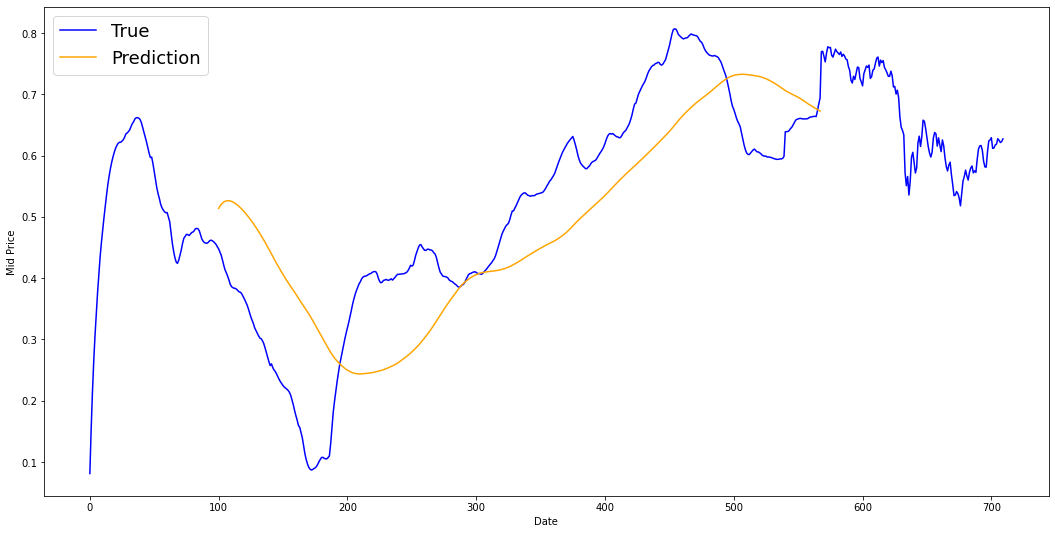

In [73]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [74]:
window_size = 10
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00012


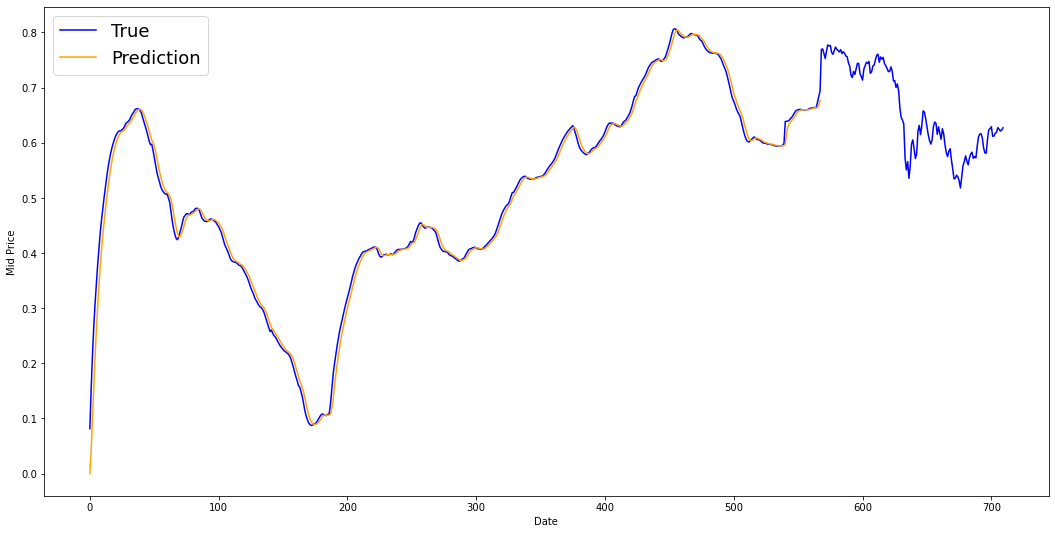

In [75]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()